<a href="https://colab.research.google.com/github/ort-eila/csiseminar/blob/main/project/step4_load_dataset_vit_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cloud
# !pip install transformers
# !pip install --upgrade transformers
# !pip install datasets
# !pip install --upgrade datasets
# !pip install transformers[torch]


# # # for CPU:
# # !pip install transformers[torch]
# # # restart
# MAC
# # !pip install tensorboard
# # !conda install pytorch torchvision torchaudio cudatoolkit=11.1 -c pytorch -c conda-forge
# # !conda install scikit-learn
# # pip install transformers[torch]
# # conda install transformers pytorch -c conda-forge -c pytorch
# # pip install accelerate -U


In [2]:
rgb_images_path = ""
import os
os.getcwd()

'/content'

In [3]:
# /Users/eilaarich-landkof-stanford/Downloads/train_validation_test_2023_08_14_20_18

In [4]:
if "eilaarich-landkof-stanford" in os.getcwd():
    rgb_images_path = os.path.join("/Users/eilaarich-landkof-stanford/Downloads/train_validation_test_2023_08_14_20_18/")
else:
    from google.colab import drive
    drive.mount("/content/gdrive")
    rgb_images_path = "/content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_VECT_TO_IMG_224_224/train_validation_test_2023_08_14_20_18"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import datasets

print("datasets version:", datasets.__version__)


datasets version: 2.14.4


In [6]:
from datasets import ClassLabel

class_labels = ClassLabel(names=["nonprogressor", "progressor"])


In [7]:
from datasets.io.abc import Dataset

ds={}
for val in ["train","validation","test"]:
  ds_with_pil_images_fld = os.path.join(rgb_images_path,'ds_with_pil_images',val)   # Output metadata JSON file name
  print("ds_with_pil_images_fld is {}".format(ds_with_pil_images_fld))
  ds[val] = Dataset.load_from_disk(ds_with_pil_images_fld)
  print("Datasets saved to disk with PIL images. ",val)
# will be used by step 4

ds_with_pil_images_fld is /content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_VECT_TO_IMG_224_224/train_validation_test_2023_08_14_20_18/ds_with_pil_images/train
Datasets saved to disk with PIL images.  train
ds_with_pil_images_fld is /content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_VECT_TO_IMG_224_224/train_validation_test_2023_08_14_20_18/ds_with_pil_images/validation
Datasets saved to disk with PIL images.  validation
ds_with_pil_images_fld is /content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_VECT_TO_IMG_224_224/train_validation_test_2023_08_14_20_18/ds_with_pil_images/test
Datasets saved to disk with PIL images.  test


In [8]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [9]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [10]:
def augmentation_fn(image):
  import torchvision.transforms as T
  transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),  # 50% chance of horizontal flip
    T.RandomVerticalFlip(p=0.5),    # 50% chance of vertical flip
    # T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    T.RandomRotation(degrees=10),   # Random rotation up to 10 degrees
  ])

  augmented_image = transform(image)
  return augmented_image

{'image_path': '/content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_VECT_TO_IMG_224_224/train_validation_test_2023_08_14_20_18/train/progressor/6103_vector_image_row_1023_col793.jpg', 'labels': 'progressor', 'pil_image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7D80D935B580>}


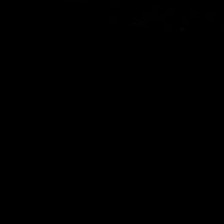

In [11]:
#test
print(ds['train'][0])
aug_example = augmentation_fn(ds['train'][0]['pil_image'])
aug_example

In [12]:
import numpy as np
do_normalize=False
do_rescale=False
do_resize=False
model_name_prefix = "norm_{}_scl_{}_resz_{}_aug_T".format(do_normalize,do_rescale,do_resize)
print("model_name_prefix is {}".format(model_name_prefix))

prepared_ds={}
def transform(example_batch):
  from PIL import Image
    # Take a list of PIL images and turn them to pixel values
  # print("example_batch is {}".format(example_batch))
  inputs = feature_extractor([Image.open(x) for x in example_batch['image_path']],
                              do_normalize=do_normalize,
                              do_rescale=do_rescale,
                              do_resize=do_resize,
                              augmentation_fn=augmentation_fn,
                              return_tensors='pt')

  # Extract PIL image objects from example_batch - need to be faster
  # pil_images = [np.array(sample['pil_image']) for sample in example_batch]
  # inputs = feature_extractor(pil_images,
  #                            do_normalize=do_normalize,
  #                            do_rescale=do_rescale,
  #                            do_resize=do_resize,
  #                            augmentation_fn=augmentation_fn,
  #                            return_tensors='pt')


    # Don't forget to include the labels!
  # inputs['labels'] = [class_labels.str2int(sample['labels']) for sample in example_batch]
  inputs['labels'] = example_batch['labels']
  return inputs

for val in ["train","validation","test"]:
  prepared_ds[val] = ds[val].with_transform(transform)

model_name_prefix is norm_False_scl_False_resz_False_aug_T


In [13]:
# prepared_ds['train']

In [14]:
import torch

def collate_fn(batch):
  return {
        # 'pixel_values': torch.stack([x['pil_image'] for x in batch]),
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        # 'labels': torch.tensor([x['labels'] for x in batch])
        'labels': torch.tensor([class_labels.str2int(x['labels']) for x in batch])
    }

    # class_labels.str2int


In [15]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-15-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [16]:
class_labels.names

['nonprogressor', 'progressor']

In [17]:
from transformers import ViTForImageClassification

labels = class_labels.names #ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Generate a date-time string
from datetime import datetime
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
current_datetime = current_datetime.replace("-","_")
current_datetime

'2023_08_15_02_08_15'

In [19]:
from transformers import EarlyStoppingCallback, IntervalStrategy

# from sklearn.utils.class_weight import compute_class_weight
# # Create callbacks
# train_dataclass_weights=class_weights,
#

lr = 5e-3
num_train_epochs = 50
batch_size = 32
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=5)
# class_weights = compute_class_weight('balanced', classes=[0, 1], y=prepared_ds["train"]["labels"])
model_name = "_lr_{}_epochs_{}_batch_size_{}".format(str(lr).replace(".","_"),num_train_epochs,batch_size)
print("model_name is {}".format(model_name))
# evaluation_strategy = "epoch"
# optimizers
# callbacks
model_output_dir = os.path.join(rgb_images_path, "model_output_dir",model_name_prefix+model_name)
print("model_output_dir is {}".format(model_output_dir))

os.makedirs(model_output_dir,exist_ok=True)
model_output_dir

tensorboard_log = os.path.join(rgb_images_path, "tensorboard",current_datetime+model_name)
os.makedirs(tensorboard_log,exist_ok=True)
tensorboard_log

model_name is _lr_0_005_epochs_50_batch_size_32
model_output_dir is /content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_VECT_TO_IMG_224_224/train_validation_test_2023_08_14_20_18/model_output_dir/norm_False_scl_False_resz_False_aug_T_lr_0_005_epochs_50_batch_size_32


'/content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_VECT_TO_IMG_224_224/train_validation_test_2023_08_14_20_18/tensorboard/2023_08_15_02_08_15_lr_0_005_epochs_50_batch_size_32'

In [20]:
tensorboard_log

'/content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_VECT_TO_IMG_224_224/train_validation_test_2023_08_14_20_18/tensorboard/2023_08_15_02_08_15_lr_0_005_epochs_50_batch_size_32'

In [21]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=model_output_dir,
  per_device_train_batch_size=batch_size,
  evaluation_strategy = "epoch",
  logging_strategy = "epoch",
  save_strategy = "epoch",
  num_train_epochs=num_train_epochs,
  save_steps=100,
  eval_steps = 50,
  logging_steps=10,
  learning_rate=lr,
  save_total_limit=5,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  # fp16=False,  # Disable mixed precision training. The True had error issues
  fp16_opt_level="O2",  # Specify optimization level
  logging_dir=tensorboard_log, # Set the logging directory
)


In [22]:
prepared_ds

{'train': Dataset({
     features: ['image_path', 'labels', 'pil_image'],
     num_rows: 30519
 }),
 'validation': Dataset({
     features: ['image_path', 'labels', 'pil_image'],
     num_rows: 6539
 }),
 'test': Dataset({
     features: ['image_path', 'labels', 'pil_image'],
     num_rows: 6542
 })}

In [23]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    callbacks = [early_stopping_callback],
    tokenizer=feature_extractor,
    # train_dataclass_weights=class_weights,
)

In [ ]:
train_results = trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

In [ ]:
prepared_ds['test']

In [ ]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'dcis-eila',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)